# Custom loss neural network evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

from utils import get_label, get_multi_label, plot_roc, evaluate, Imputer, Vectorizer, Splitter
from models import WeightedLogisticRegression, WeightedNeuralNetwork

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def label_from_multi(y_multi):
    return torch.tensor([1 if y == 0 else 0 for y in y_multi]).float()

In [3]:
data = pd.read_csv("data/train.tsv", sep="\t")
x_all, y_all_multi = data.drop("label", axis=1), get_multi_label(data)
x_train, x_test, y_train_multi, y_test_multi = train_test_split(data.drop("label", axis=1), get_multi_label(data), random_state=RANDOM_SEED)
y_train = label_from_multi(y_train_multi)
y_test = label_from_multi(y_test_multi)
y_all = label_from_multi(y_all_multi)

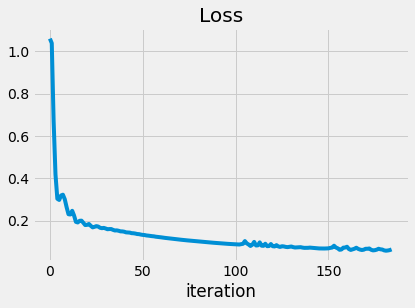

Accuracy: 88.74
F-1 score: 0.2532


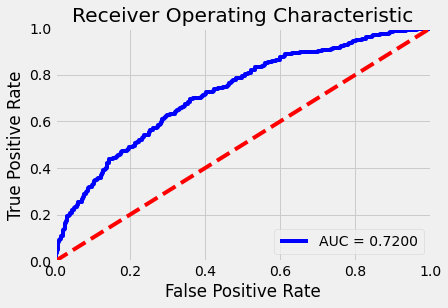

0.719975412512726

In [20]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("job", impute_vectorize, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


loss_weights = (0.4, 1, 1.6, 2.2, 2.8)


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("predict", WeightedNeuralNetwork(loss_weights=loss_weights, hidden_size=512, lr=0.01, l1=1e-6, l2=0.0002, max_iter=1000, tol=1e-5, plot_loss=True))
])

pipeline.fit(x_train, y_train_multi);
evaluate(pipeline, x_test, y_test)